## Summary:
Plot of subset of TCs making landfall in the Philippines.

## Step 0: Load packages

In [1]:
reset

Once deleted, variables cannot be recovered. Proceed (y/[n])? y


In [2]:
#!/usr/bin/env python

# standard packages
from __future__ import division
from builtins import str
from builtins import range
from past.utils import old_div
import numpy as np
import datetime
import pickle
from netCDF4 import Dataset
import sys
import matplotlib.pyplot as plt
import xarray as xr
import pandas as pd
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from scipy.interpolate import griddata
from pyproj import Proj, transform
import math
import multiprocessing
from joblib import Parallel, delayed
import time
from os import path

# specialized CHAZ packages
from chaz.utility import knaff15
from pygplib3 import readbst
from pygplib3 import landfall as ld
from tcrisk.hazard import windfield, landfall_in_box, timepoints_around_landfall


In [3]:
# Root directory: change to where data downloaded to
root_dir = '/data2/jbaldwin/WCAS2023'

In [4]:
# # For timing the script
# start_time = time.time()

In [5]:
# Bounding box for the Philippines
lonmin = 117.17427453
latmin = 5.58100332277
lonmax = 126.537423944
latmax = 18.5052273625


In [6]:
# IBTrACS

# Load subset data of landfalling storms over Philippines
dat = xr.open_dataset(root_dir+'/HAZARD/TC_TRACKS/IBTrACS/ibtracsv04r00_landfall_philippines.nc')
lon = np.array(dat.lon)
lat = np.array(dat.lat)
wspd = np.array(dat.wspd)/1.944 #convert from kts to m/s


# Interpolate to 15-min timesteps
nscale = 24 # convert from 6-hr to 15-min timesteps (factor of 6*4=24)
lon = ld.rescale_matrix(lon,nscale,0) # int for time interpolated 
lat = ld.rescale_matrix(lat,nscale,0)
wspd = ld.rescale_matrix(wspd,nscale,0)


# Calculate which storms and when make landfall in Philippines
llon_midpoint = 180
nSlandfall_all_phi, iTlandfall_all_phi, nSlandfall_phi = landfall_in_box(lonmin,lonmax,latmin,latmax,lon,lat,wspd,llon_midpoint)


# Select time of first landfall for each of the Philippines storms
iTlandfall_first_phi = []
for i in range(np.shape(lon)[1]):
    j = np.where(np.array(nSlandfall_all_phi)==i)[0][0]
    iTlandfall_first_phi.append(iTlandfall_all_phi[j])

/home/jbaldwin/.conda/envs/worldbank/lib/python3.7/site-packages/scipy/io/netcdf.py:317: RuntimeWarning: Cannot close a netcdf_file opened with mmap=True, when netcdf_variables or arrays referring to its data still exist. All data arrays obtained from such files refer directly to data on disk, and must be copied before the file can be cleanly closed. (See netcdf_file docstring for more information on mmap.)
  ), category=RuntimeWarning)


In [10]:
# CHAZ

# Load subset data of landfalling storms over Philippines
#datC = xr.open_dataset('/data2/clee/ERAInterim/ERAInterim_wpc_000.nc').sel(ensembleNum=1).rename({'longitude':'lon','latitude':'lat','Mwspd':'wspd'}) # select 0th ensemble number
datC = xr.open_dataset(root_dir+'/HAZARD/TC_TRACKS/CHAZ/ERAInterim_wpc_000_landfall_philippines.nc').sel(ensembleNum=1) # select 0th ensemble number
lonC = np.array(datC.lon)
latC = np.array(datC.lat)
wspdC = np.array(datC.wspd)/1.944 #convert from kts to m/s


# Interpolate to 15-min timesteps
nscale = 24 # convert from 6-hr to 15-min timesteps (factor of 6*4=24)
lonC = ld.rescale_matrix(lonC,nscale,0) # int for time interpolated 
latC = ld.rescale_matrix(latC,nscale,0)
wspdC = ld.rescale_matrix(wspdC,nscale,0)


# Calculate which storms and when make landfall in Philippines
llon_midpoint = 180
nSlandfall_all_phiC, iTlandfall_all_phiC, nSlandfall_phiC = landfall_in_box(lonmin,lonmax,latmin,latmax,lonC,latC,wspdC,llon_midpoint)

# Select data only for storms that make landfall in the Philippines
lonC_landfall = lonC[:,nSlandfall_phiC]
latC_landfall = latC[:,nSlandfall_phiC]
wspdC_landfall = wspdC[:,nSlandfall_phiC]

# Calculate which storms and when make landfall in Philippines
llon_midpoint = 180
nSlandfall_all_phiC, iTlandfall_all_phiC, nSlandfall_phiC = landfall_in_box(lonmin,lonmax,latmin,latmax,lonC_landfall,latC_landfall,wspdC_landfall,llon_midpoint)

# Select time of first landfall for each of the Philippines storms
iTlandfall_first_phiC = []
for i in range(np.shape(lonC_landfall)[1]):
    j = np.where(np.array(nSlandfall_all_phiC)==i)[0][0]
    iTlandfall_first_phiC.append(iTlandfall_all_phiC[j])
    

/home/jbaldwin/.conda/envs/worldbank/lib/python3.7/site-packages/matplotlib/tight_layout.py:176: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 
  warnings.warn('Tight layout not applied. The left and right margins '


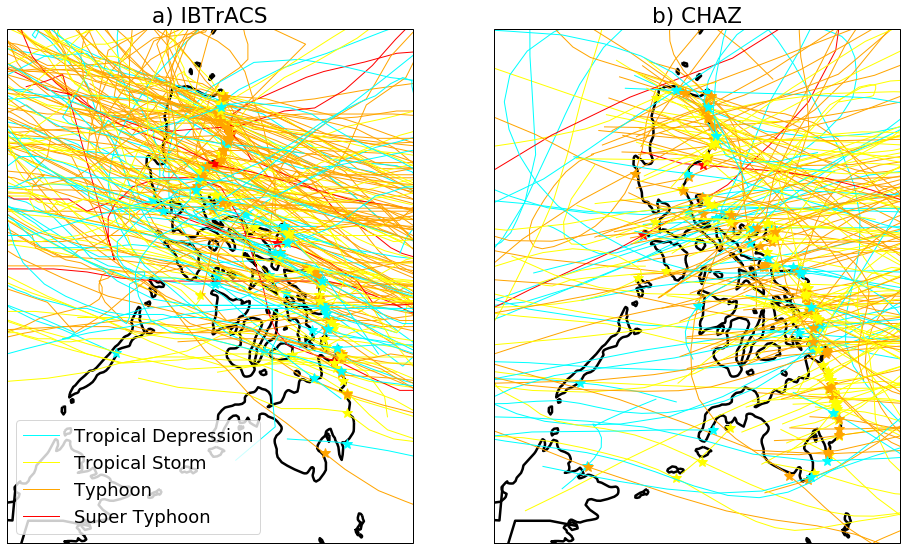

In [11]:
# Plotting tracks and landfall locations
# ratings of storm intensity taken from here: https://en.wikipedia.org/wiki/Tropical_cyclone_scales

plt.rcParams.update({'font.size': 18})
plt.figure(figsize=(16, 12))


# IBTrACS

ax1 = plt.subplot(121,projection=ccrs.PlateCarree())

lw = 1

for n in np.arange(0,200):#range(np.shape(lon)[1]):
    i = iTlandfall_first_phi[n]
    wspd_landfall = wspd[i,n]
    if wspd_landfall <= 33/1.944:
        name = 'Tropical Depression'
        color = 'cyan'
    elif wspd_landfall <= 63/1.944:
        name = 'Tropical Storm'
        color = 'yellow'
    elif wspd_landfall <= 129/1.944:
        name = 'Typhoon'
        color = 'orange'
    elif wspd_landfall > 129/1.944:
        name = 'Super Typhoon'
        color = 'red'
    plt.plot(lon[:,n],lat[:,n],linewidth=lw,color=color)
    plt.plot(lon[i,n],lat[i,n],'*',color=color,markersize=10)
    
plt.plot(1,1,linewidth=lw,color='cyan',label='Tropical Depression')
plt.plot(1,1,linewidth=lw,color='yellow',label='Tropical Storm')
plt.plot(1,1,linewidth=lw,color='orange',label='Typhoon')
plt.plot(1,1,linewidth=lw,color='red',label='Super Typhoon')

plt.legend()

buffer = 2
ax1.set_extent([lonmin-buffer,lonmax+buffer,latmin-buffer,latmax+buffer])
ax1.coastlines(resolution='50m',linewidth=2.5)
ax1.add_feature(cfeature.BORDERS,linewidth=2.5)
ax1.set_title('a) IBTrACS')


# CHAZ

ax2 = plt.subplot(122,projection=ccrs.PlateCarree())

lw = 1

for n in np.arange(0,200):#range(np.shape(lon)[1]):
    i = iTlandfall_first_phiC[n]
    wspd_landfall = wspdC_landfall[i,n]
    if wspd_landfall <= 33/1.944:
        name = 'Tropical Depression'
        color = 'cyan'
    elif wspd_landfall <= 63/1.944:
        name = 'Tropical Storm'
        color = 'yellow'
    elif wspd_landfall <= 129/1.944:
        name = 'Typhoon'
        color = 'orange'
    elif wspd_landfall > 129/1.944:
        name = 'Super Typhoon'
        color = 'red'
    plt.plot(lonC_landfall[:,n],latC_landfall[:,n],linewidth=lw,color=color)
    plt.plot(lonC_landfall[i,n],latC_landfall[i,n],'*',color=color,markersize=10)

ax2.set_extent([lonmin-buffer,lonmax+buffer,latmin-buffer,latmax+buffer])
ax2.coastlines(resolution='50m',linewidth=2.5)
ax2.add_feature(cfeature.BORDERS,linewidth=2.5)
ax2.set_title('b) CHAZ')

plt.tight_layout()

# plt.savefig(root_dir+'/FIGURES/landfall_tcs.png',dpi=300)
# plt.savefig(root_dir+'/FIGURES/landfall_tcs.pdf')